### 数据导入和预处理

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import warnings

# 过滤sklearn的数值计算警告
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')

### heart建模

In [24]:
# 读取已清理的数据
df_heart = pd.read_csv("cleaned_heart.csv")

# 对分类变量进行One-Hot编码
df_heart = pd.get_dummies(df_heart, columns=[
    'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS'
], drop_first=True)

# 将目标变量转换为数值格式
le = LabelEncoder()
df_heart['HeartDisease'] = le.fit_transform(df_heart['HeartDisease'])
print(f"目标变量映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 分离特征和目标变量
X = df_heart.drop('HeartDisease', axis=1)
y = df_heart['HeartDisease']

# 确保数据类型正确
X = X.astype('float64')

# 数值稳定性检查
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().any().any():
    X = X.fillna(X.median())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用RobustScaler进行特征缩放
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将缩放后的数据转换回DataFrame格式
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

目标变量映射: {'No': np.int64(0), 'Yes': np.int64(1)}


In [25]:
# 构建逻辑回归模型
model = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    C=1.0,
    max_iter=2000
)

# 训练模型
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print(f"\n--- Heart Disease Prediction Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", class_report)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Heart Disease Prediction')
plt.legend(loc='lower right')
plt.savefig("heart_roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


--- Heart Disease Prediction Model Evaluation ---
Accuracy: 0.8913
ROC AUC: 0.9334
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [26]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8478, ROC AUC: 0.9247
Random Forest Feature Importance:
               Feature  Importance
13         ST_Slope_Up    0.198940
12       ST_Slope_Flat    0.152213
4              Oldpeak    0.114999
3                MaxHR    0.099089
11  ExerciseAngina_Yes    0.085563
0                  Age    0.067072
2          Cholesterol    0.064544
1            RestingBP    0.057500
6    ChestPainType_ATA    0.039073
5                Sex_M    0.036981


In [27]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.8478, ROC AUC: 0.9358


In [28]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.8804, ROC AUC: 0.9225
Gradient Boosting Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.509725
4                   Oldpeak    0.097396
3                     MaxHR    0.082177
2               Cholesterol    0.057528
5                     Sex_M    0.044909
7         ChestPainType_NAP    0.041596
11       ExerciseAngina_Yes    0.033526
1                 RestingBP    0.032022
0                       Age    0.030950
14  FastingBS_Normal (≤120)    0.026509


In [29]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.8750, ROC AUC: 0.9369


In [30]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1  # 减少输出信息
)

lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

# LightGBM特征重要性
lgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Feature Importance (Top 10):")
print(lgb_importance.head(10))

LightGBM - Accuracy: 0.8533, ROC AUC: 0.9132
LightGBM Feature Importance (Top 10):
               Feature  Importance
3                MaxHR         364
2          Cholesterol         318
4              Oldpeak         258
0                  Age         257
1            RestingBP         237
5                Sex_M          78
7    ChestPainType_NAP          66
9    RestingECG_Normal          51
12       ST_Slope_Flat          49
11  ExerciseAngina_Yes          43


In [31]:
# XGBoost模型
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0  # 减少输出信息
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8587, ROC AUC: 0.9103
XGBoost Feature Importance (Top 10):
                    Feature  Importance
13              ST_Slope_Up    0.710981
5                     Sex_M    0.033052
7         ChestPainType_NAP    0.031449
6         ChestPainType_ATA    0.030140
11       ExerciseAngina_Yes    0.029491
14  FastingBS_Normal (≤120)    0.026928
4                   Oldpeak    0.024799
3                     MaxHR    0.018965
8          ChestPainType_TA    0.017286
1                 RestingBP    0.015886


Extended Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
4                  KNN  0.875000  0.936872
2                  SVM  0.847826  0.935796
0  Logistic Regression  0.891304  0.933405
1        Random Forest  0.847826  0.924677
3    Gradient Boosting  0.880435  0.922525
5             LightGBM  0.853261  0.913199
6              XGBoost  0.858696  0.910330


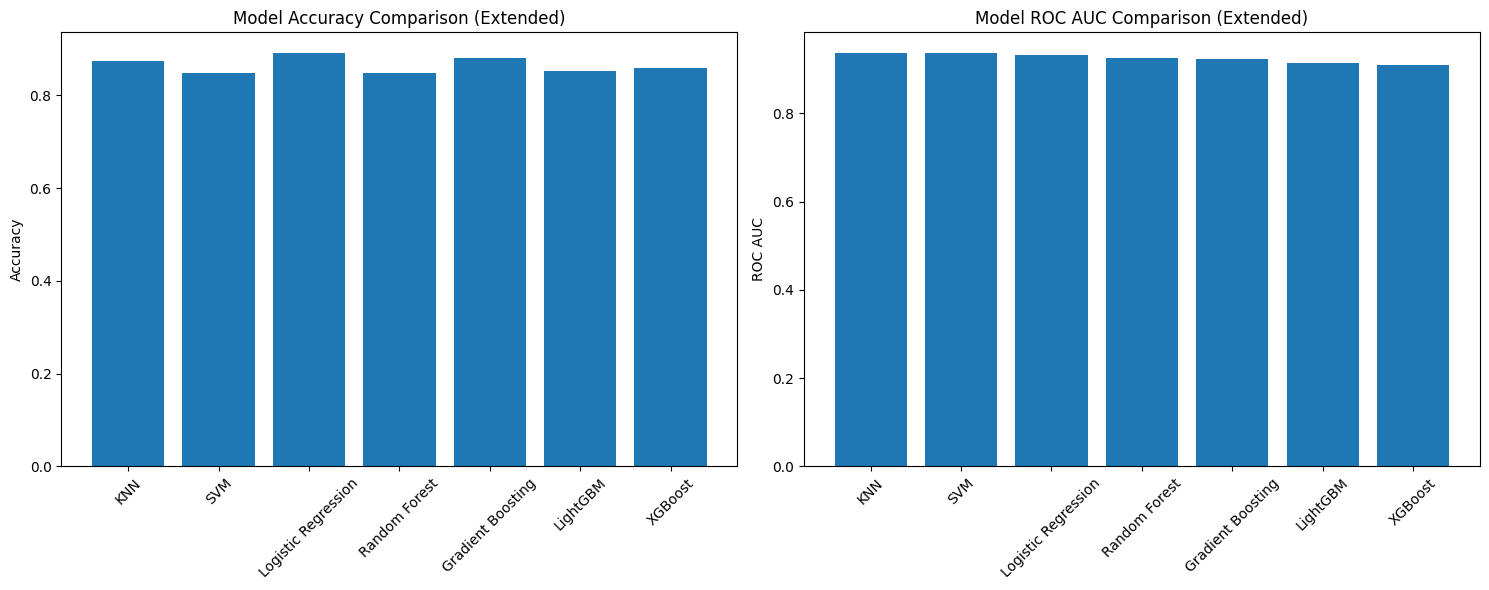

Best performing model: KNN


In [32]:
# 模型性能比较
model_results_extended = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("Extended Model Performance Comparison:")
print(model_results_extended)

# 可视化扩展比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_extended['Model'], model_results_extended['Accuracy'])
plt.title('Model Accuracy Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(model_results_extended['Model'], model_results_extended['ROC_AUC'])
plt.title('Model ROC AUC Comparison (Extended)')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')

plt.tight_layout()
plt.savefig("extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_extended.iloc[0]['Model']}")

In [35]:
# 交叉验证评估
models_extended = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0)
}

print("=== 交叉验证结果 ===")
cv_results_extended = {}
for name, model in models_extended.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_results_extended[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.9155 (+/- 0.0728)
Random Forest - CV ROC AUC: 0.9228 (+/- 0.0525)
SVM - CV ROC AUC: 0.9154 (+/- 0.0587)
Gradient Boosting - CV ROC AUC: 0.9235 (+/- 0.0401)
KNN - CV ROC AUC: 0.8934 (+/- 0.0703)
LightGBM - CV ROC AUC: 0.9180 (+/- 0.0357)
XGBoost - CV ROC AUC: 0.9166 (+/- 0.0327)


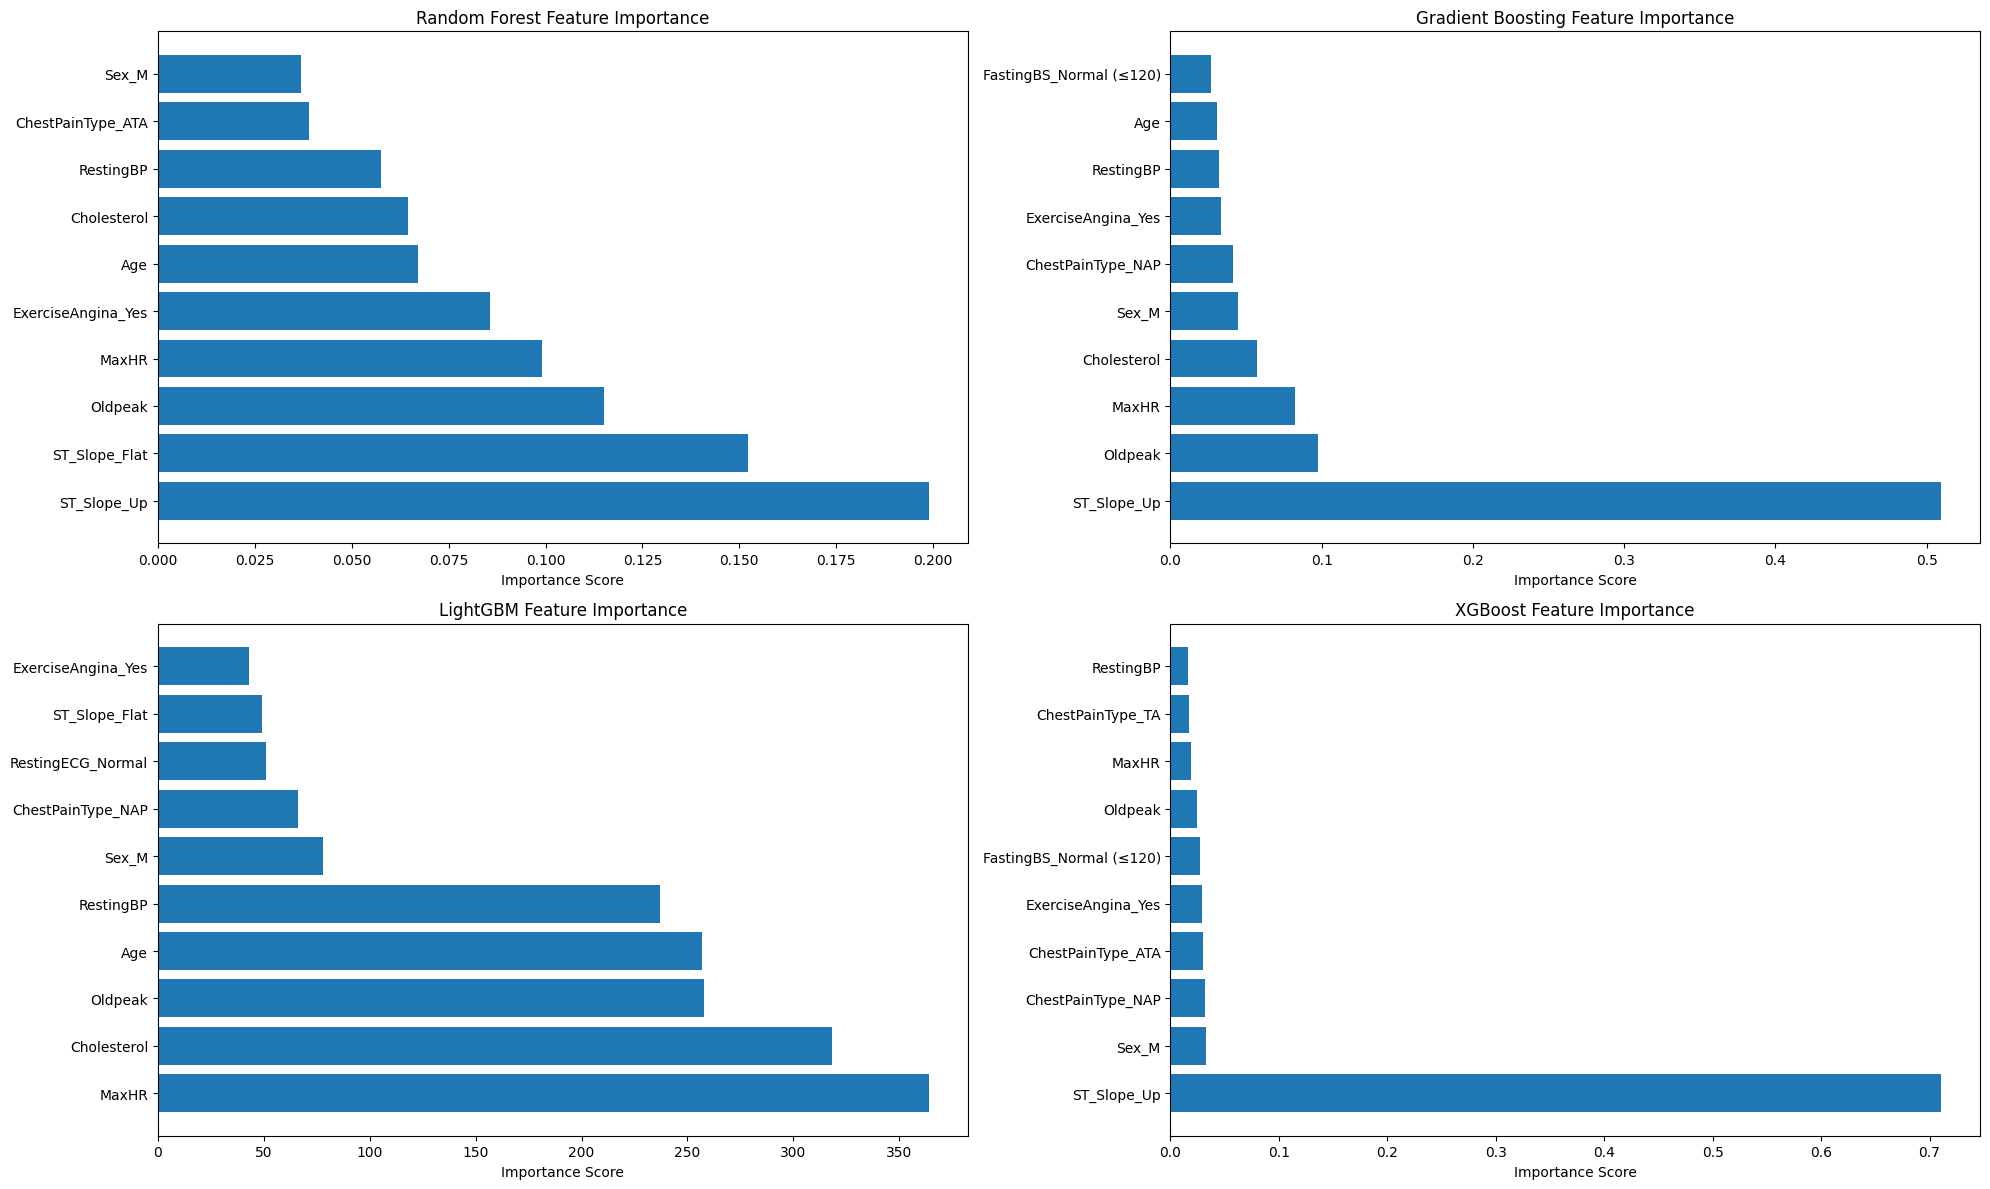

In [34]:
# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'{name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

### stroke建模

In [38]:
# 读取已清理的数据
df_stroke = pd.read_csv("cleaned_stroke.csv")

# 特征工程和编码
df_stroke = pd.get_dummies(df_stroke,
                           columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',
                                    'hypertension', 'heart_disease'], drop_first=True)

# 编码目标变量
le = LabelEncoder()
df_stroke['stroke_encoded'] = le.fit_transform(df_stroke['stroke'])
print(f"目标变量映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 分离特征和目标变量
X = df_stroke.drop(['stroke', 'stroke_encoded'], axis=1)
y = df_stroke['stroke_encoded']

# 添加：数据不平衡分析
print("\n=== 数据不平衡分析 ===")
print(f"特征数量: {X.shape[1]}")
print(f"目标变量分布:\n{y.value_counts()}")
print(f"正例比例: {y.mean():.4f}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

目标变量映射: {'No': np.int64(0), 'Yes': np.int64(1)}

=== 数据不平衡分析 ===
特征数量: 15
目标变量分布:
stroke_encoded
0    4860
1     249
Name: count, dtype: int64
正例比例: 0.0487



=== 阈值优化 ===
默认阈值(0.5)预测正例数: 302
最佳阈值: 0.8464
最佳阈值预测正例数: 67

--- Stroke Prediction Model Evaluation ---
Accuracy (默认阈值): 0.7339
Accuracy (最佳阈值): 0.9266
ROC AUC: 0.8408

Classification Report (默认阈值):
               precision    recall  f1-score   support

   No Stroke       0.99      0.73      0.84       972
      Stroke       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.94      0.73      0.81      1022


Classification Report (最佳阈值 0.846):
               precision    recall  f1-score   support

   No Stroke       0.97      0.95      0.96       972
      Stroke       0.31      0.42      0.36        50

    accuracy                           0.93      1022
   macro avg       0.64      0.69      0.66      1022
weighted avg       0.94      0.93      0.93      1022



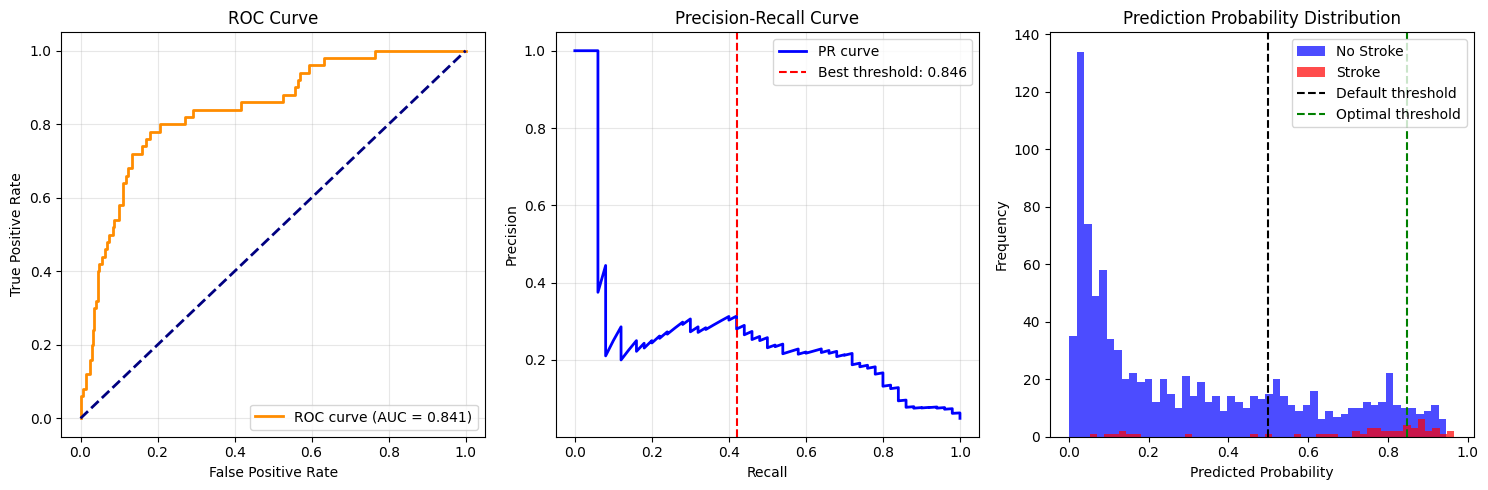


Feature Importance (Logistic Regression Coefficients):
                         Feature  Coefficient
0                           age     1.912668
8            work_type_children     0.377284
1             avg_glucose_level     0.209822
13             hypertension_Yes     0.186500
5        work_type_Never_worked    -0.166963
2                           bmi     0.112997
11  smoking_status_never smoked    -0.107870
12        smoking_status_smokes     0.105739
9          Residence_type_Urban     0.085275
4              ever_married_Yes    -0.081655


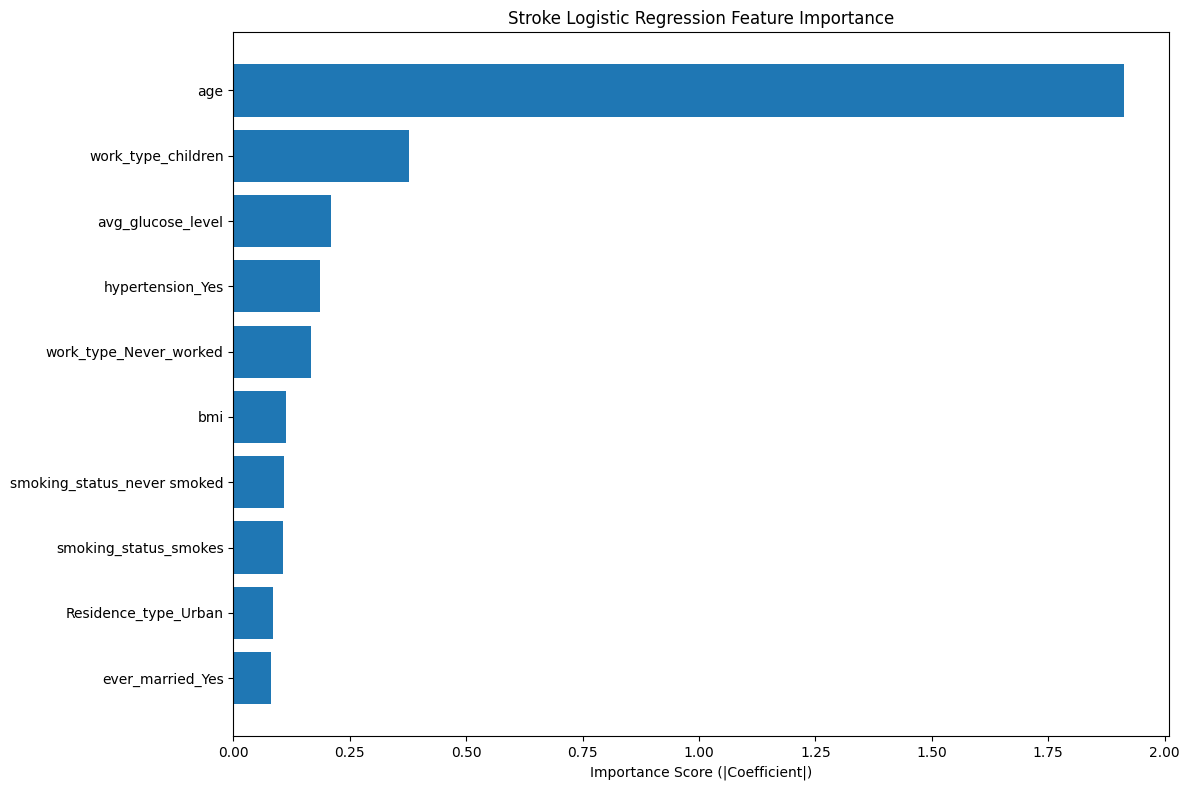

In [56]:
# 使用平衡权重的逻辑回归模型
model = LogisticRegression(
    random_state=42,
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# 模型预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 找到最佳分类阈值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"\n=== 阈值优化 ===")
print(f"默认阈值(0.5)预测正例数: {(y_pred == 1).sum()}")
print(f"最佳阈值: {best_threshold:.4f}")

# 使用最佳阈值重新预测
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
print(f"最佳阈值预测正例数: {(y_pred_optimal == 1).sum()}")

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 默认阈值评估
class_report = classification_report(
    y_test, y_pred,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

# 最佳阈值评估
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
class_report_optimal = classification_report(
    y_test, y_pred_optimal,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

print(f"\n--- Stroke Prediction Model Evaluation ---")
print(f"Accuracy (默认阈值): {accuracy:.4f}")
print(f"Accuracy (最佳阈值): {accuracy_optimal:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report (默认阈值):\n", class_report)
print(f"\nClassification Report (最佳阈值 {best_threshold:.3f}):\n", class_report_optimal)

# 绘制综合分析图
plt.figure(figsize=(15, 5))

# ROC曲线
plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Precision-Recall曲线
plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
plt.axvline(x=recall[best_threshold_idx], color='red', linestyle='--',
            label=f'Best threshold: {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测概率分布
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='No Stroke', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Stroke', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold')
plt.axvline(x=best_threshold, color='green', linestyle='--', label='Optimal threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.tight_layout()
plt.savefig("stroke_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n", feature_importance.head(10))

# 逻辑回归特征
lr_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])  # 使用系数绝对值作为重要性
}).sort_values(by='Importance', ascending=False)

# 可视化逻辑回归特征重要性
plt.figure(figsize=(12, 8))
top_features = lr_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Stroke Logistic Regression Feature Importance')
plt.xlabel('Importance Score (|Coefficient|)')
plt.gca().invert_yaxis()  # 让最重要的特征显示在顶部
plt.tight_layout()
plt.savefig("stroke_logistic_regression_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# 随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, ROC AUC: {rf_roc_auc:.4f}")

# 特征重要性
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(10))

Random Forest - Accuracy: 0.8992, ROC AUC: 0.8069
Random Forest Feature Importance:
                    Feature  Importance
0                       age    0.432076
2                       bmi    0.158503
1         avg_glucose_level    0.149185
4          ever_married_Yes    0.044819
13         hypertension_Yes    0.041380
8        work_type_children    0.023989
14        heart_disease_Yes    0.022613
9      Residence_type_Urban    0.020699
7   work_type_Self-employed    0.020384
3               gender_Male    0.020049


In [42]:
# SVM模型
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)

print(f"SVM - Accuracy: {svm_accuracy:.4f}, ROC AUC: {svm_roc_auc:.4f}")

SVM - Accuracy: 0.7661, ROC AUC: 0.7961


In [43]:
# 梯度提升模型
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, ROC AUC: {gb_roc_auc:.4f}")

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Top 10):")
print(gb_importance.head(10))

Gradient Boosting - Accuracy: 0.9511, ROC AUC: 0.8315
Gradient Boosting Feature Importance (Top 10):
                        Feature  Importance
0                           age    0.417807
2                           bmi    0.212736
1             avg_glucose_level    0.203851
13             hypertension_Yes    0.047244
4              ever_married_Yes    0.025214
14            heart_disease_Yes    0.022735
12        smoking_status_smokes    0.021777
11  smoking_status_never smoked    0.015488
3                   gender_Male    0.011658
7       work_type_Self-employed    0.008158


In [44]:
# KNN模型
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.4f}, ROC AUC: {knn_roc_auc:.4f}")

KNN - Accuracy: 0.9423, ROC AUC: 0.6126


In [51]:
# LightGBM模型
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    objective='binary',
    metric='binary_logloss',
    verbose=-1,
    class_weight='balanced'
)

# 使用DataFrame格式训练和预测
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

lgb_model.fit(X_train_df, y_train)
lgb_pred = lgb_model.predict(X_test_df)
lgb_pred_proba = lgb_model.predict_proba(X_test_df)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, ROC AUC: {lgb_roc_auc:.4f}")

LightGBM - Accuracy: 0.8728, ROC AUC: 0.8187


In [48]:
# XGBoost模型
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=scale_pos_weight  # 处理不平衡数据
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, ROC AUC: {xgb_roc_auc:.4f}")

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance.head(10))

XGBoost - Accuracy: 0.8796, ROC AUC: 0.7967
XGBoost Feature Importance (Top 10):
                        Feature  Importance
0                           age    0.274000
1             avg_glucose_level    0.083442
2                           bmi    0.080303
12        smoking_status_smokes    0.068457
11  smoking_status_never smoked    0.065065
13             hypertension_Yes    0.064413
6             work_type_Private    0.062787
4              ever_married_Yes    0.054395
7       work_type_Self-employed    0.051226
3                   gender_Male    0.050756



Stroke Model Performance Comparison:
                 Model  Accuracy   ROC_AUC
0  Logistic Regression  0.926614  0.840802
3    Gradient Boosting  0.951076  0.831543
5             LightGBM  0.872798  0.818704
1        Random Forest  0.899217  0.806914
6              XGBoost  0.879648  0.796728
2                  SVM  0.766145  0.796132
4                  KNN  0.942270  0.612644


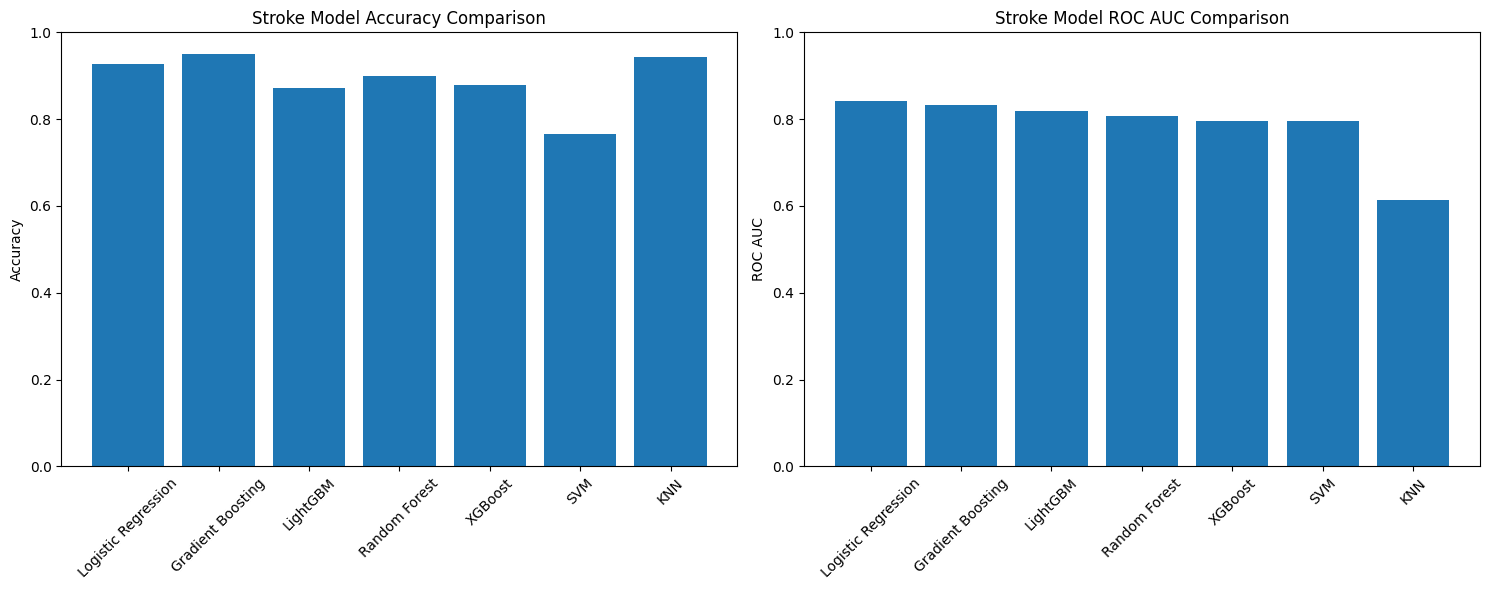

Best performing model: Logistic Regression


In [52]:
# 模型性能比较
model_results_stroke = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'KNN', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy_optimal, rf_accuracy, svm_accuracy, gb_accuracy, knn_accuracy, lgb_accuracy, xgb_accuracy],
    'ROC_AUC': [roc_auc, rf_roc_auc, svm_roc_auc, gb_roc_auc, knn_roc_auc, lgb_roc_auc, xgb_roc_auc]
}).sort_values(by='ROC_AUC', ascending=False)

print("\nStroke Model Performance Comparison:")
print(model_results_stroke)

# 可视化比较
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(model_results_stroke['Model'], model_results_stroke['Accuracy'])
plt.title('Stroke Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(model_results_stroke['Model'], model_results_stroke['ROC_AUC'])
plt.title('Stroke Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("stroke_extended_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best performing model: {model_results_stroke.iloc[0]['Model']}")


=== Stroke 交叉验证结果 ===
Logistic Regression - CV ROC AUC: 0.8394 (+/- 0.0423)
Random Forest - CV ROC AUC: 0.8051 (+/- 0.0780)
SVM - CV ROC AUC: 0.7706 (+/- 0.0536)
Gradient Boosting - CV ROC AUC: 0.8363 (+/- 0.0660)
KNN - CV ROC AUC: 0.5968 (+/- 0.0660)
LightGBM - CV ROC AUC: 0.8277 (+/- 0.0727)
XGBoost - CV ROC AUC: 0.8044 (+/- 0.0790)


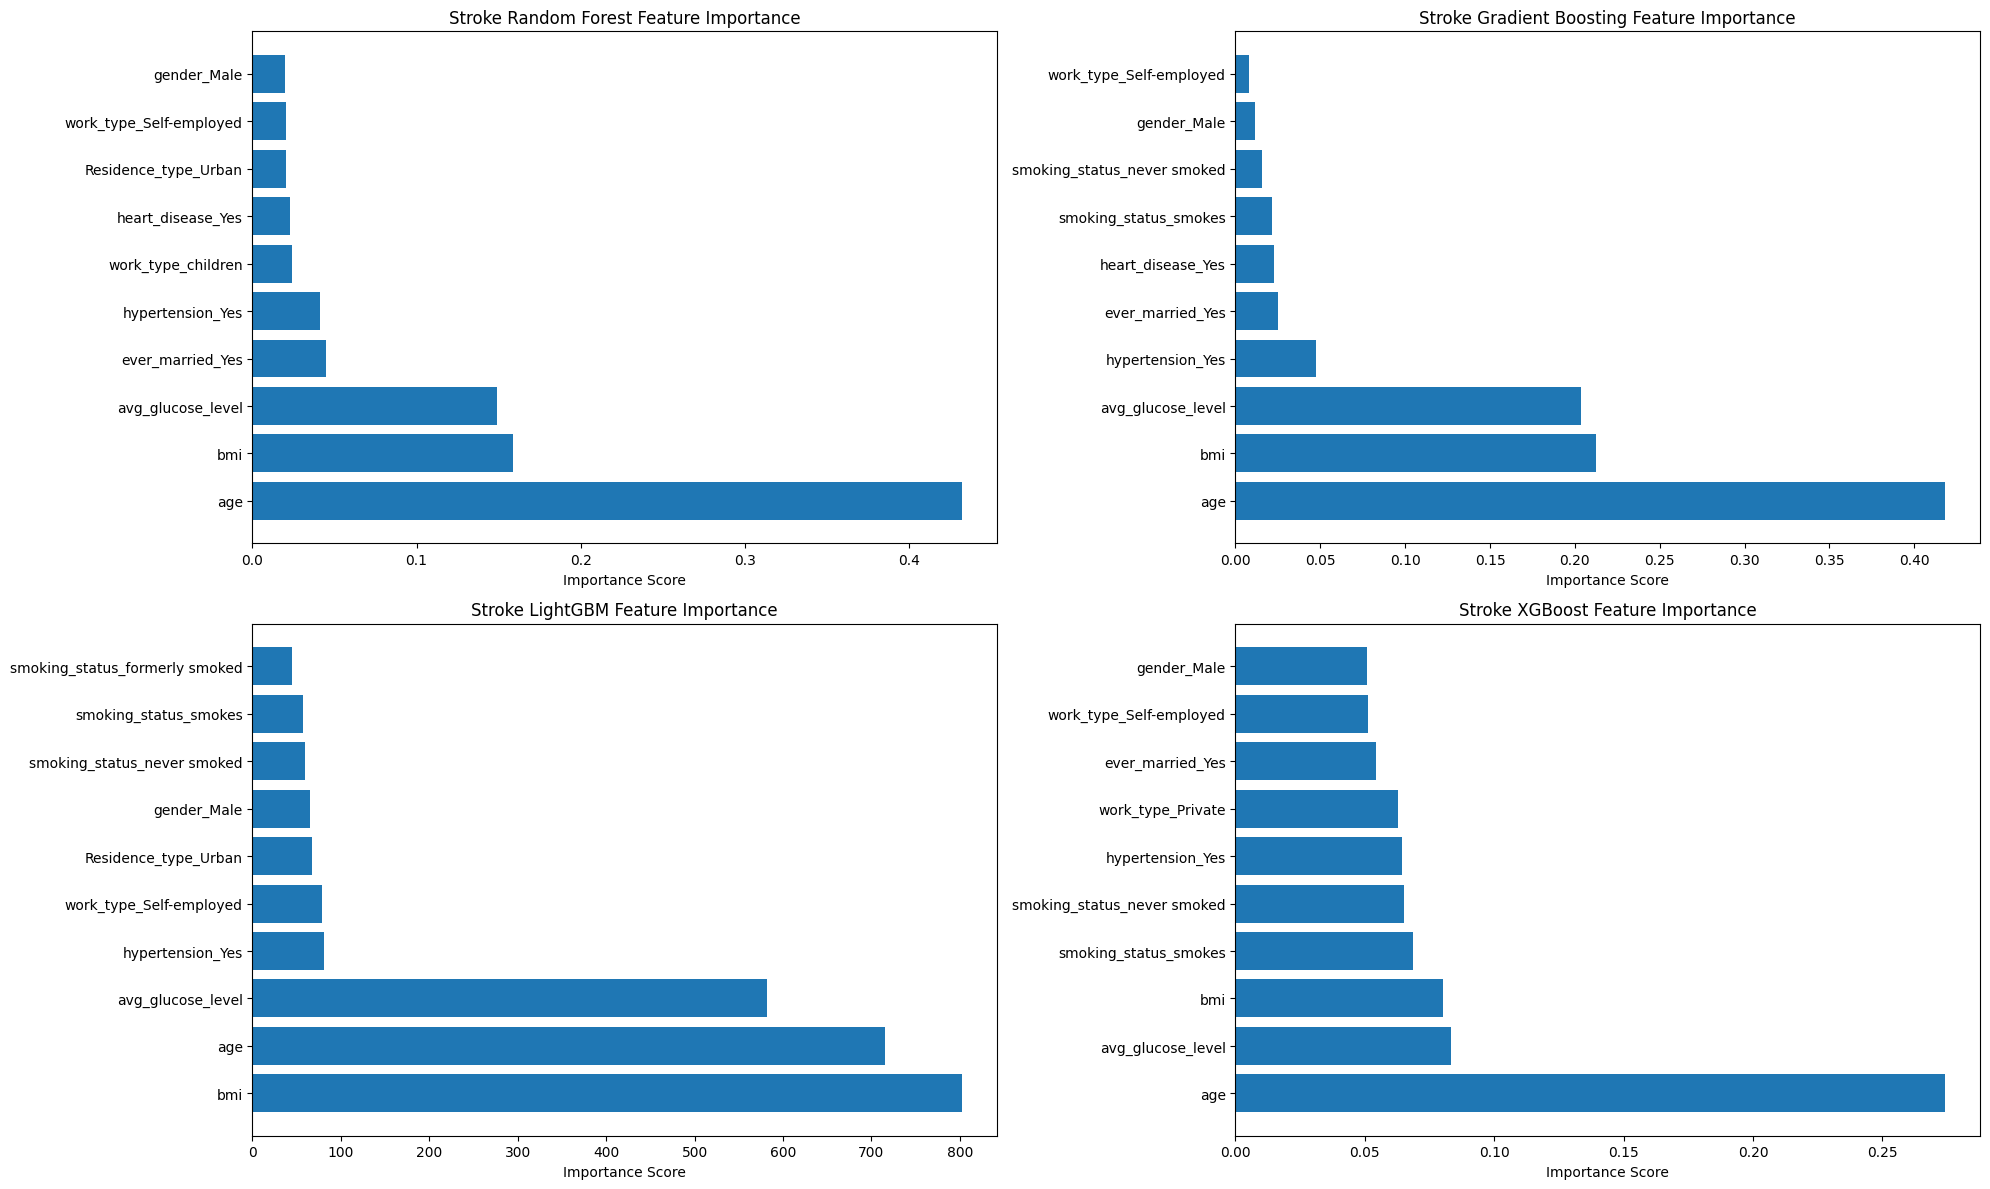


=== 最佳模型阈值优化 ===
选择最佳模型: Logistic Regression
最佳模型的最佳阈值: 0.8464
最佳模型 + 最佳阈值准确率: 0.9266

最佳模型分类报告:
              precision    recall  f1-score   support

   No Stroke       0.97      0.95      0.96       972
      Stroke       0.31      0.42      0.36        50

    accuracy                           0.93      1022
   macro avg       0.64      0.69      0.66      1022
weighted avg       0.94      0.93      0.93      1022



In [53]:
# 交叉验证评估
models_stroke = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced',
                                              max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, scale_pos_weight=scale_pos_weight)
}

print("\n=== Stroke 交叉验证结果 ===")
cv_results_stroke = {}
for name, model in models_stroke.items():
    cv_scores = cross_val_score(model, X_train_df, y_train, cv=5, scoring='roc_auc')
    cv_results_stroke[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }
    print(f"{name} - CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 特征重要性综合分析
plt.figure(figsize=(20, 12))

# 显示树模型的特征重要性
tree_models_stroke = [
    ('Random Forest', rf_importance),
    ('Gradient Boosting', gb_importance),
    ('LightGBM', lgb_importance),
    ('XGBoost', xgb_importance)
]

for i, (name, importance_df) in enumerate(tree_models_stroke):
    plt.subplot(2, 2, i + 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.title(f'Stroke {name} Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.savefig("stroke_tree_models_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 针对stroke数据的阈值优化分析
print("\n=== 最佳模型阈值优化 ===")
best_model_name = model_results_stroke.iloc[0]['Model']
print(f"选择最佳模型: {best_model_name}")

# 获取最佳模型的预测概率
if best_model_name == 'Random Forest':
    best_pred_proba = rf_pred_proba
elif best_model_name == 'XGBoost':
    best_pred_proba = xgb_pred_proba
elif best_model_name == 'LightGBM':
    best_pred_proba = lgb_pred_proba
elif best_model_name == 'Gradient Boosting':
    best_pred_proba = gb_pred_proba
elif best_model_name == 'SVM':
    best_pred_proba = svm_pred_proba
elif best_model_name == 'KNN':
    best_pred_proba = knn_pred_proba
else:
    best_pred_proba = y_pred_proba

# 为最佳模型找最佳阈值
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, best_pred_proba)
f1_scores_best = 2 * (precision_best * recall_best) / (precision_best + recall_best)
best_threshold_idx_best = np.argmax(f1_scores_best)
best_threshold_best = thresholds_best[best_threshold_idx_best]

print(f"最佳模型的最佳阈值: {best_threshold_best:.4f}")

# 使用最佳阈值重新评估
y_pred_best_optimal = (best_pred_proba >= best_threshold_best).astype(int)
accuracy_best_optimal = accuracy_score(y_test, y_pred_best_optimal)
class_report_best_optimal = classification_report(
    y_test, y_pred_best_optimal,
    zero_division=0,
    target_names=['No Stroke', 'Stroke']
)

print(f"最佳模型 + 最佳阈值准确率: {accuracy_best_optimal:.4f}")
print(f"\n最佳模型分类报告:\n{class_report_best_optimal}")

In [54]:
# 逻辑回归特征
lr_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])  # 使用系数绝对值作为重要性
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance (Top 10):")
print(lr_importance.head(10))

# 可视化逻辑回归特征重要性
plt.figure(figsize=(12, 8))
top_features = lr_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Stroke Logistic Regression Feature Importance')
plt.xlabel('Importance Score (|Coefficient|)')
plt.gca().invert_yaxis()  # 让最重要的特征显示在顶部
plt.tight_layout()
plt.savefig("stroke_logistic_regression_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

AttributeError: Coefficients are not defined for Booster type None